## Predict 2 meter temperature with sea surface temperature using LSTM
This notebook serves as an example of a basic workflow of data driven forecasting using deep learning with `s2spy` & `lilio` packages. <br>
The model and results are further evaluated using an XAI explainer called LIME (https://github.com/marcotcr/lime). <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset with LSTM network. <br>

Note that since LIME can only handle single timestep each time for a regression model with timeseries, this LSTM is built to perform one-to-one prediction. 

<img src="../../assets/concept_test_case.png" alt="usecase" width="500"/>

This recipe includes the following steps:
- Define a calendar (`lilio`)
- Download/load input data (`era5cli`) (test data, accessible via `era5cli`)
- Map the calendar to the data (`lilio`)
- Train-validate-test split (60%/20%/20%)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Create LSTM model (`torch`)
- Specify hyper-parameters (`wandb`)
- Train model (`torch`)
- Evaludate model

The workflow is illustrated below:

<img src="../../assets/dl.PNG" alt="Transformer" width="900"/>

In [1]:
import lilio
import numpy as np
import time as tt
import wandb
import sys
import urllib
import xarray as xr
from pathlib import Path
from s2spy import preprocess
import torch
from torch import nn
from torch.autograd import Variable

# import utils function to check the statistics of parameters
sys.path.append("../../src/")
import utils

#### Define a calendar with `lilio` to specify time range for targets and precursors.

In [2]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01")
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 1
calendar.add_intervals("precursor", "1M", gap="1M", n=periods_of_interest)

In [3]:
# check calendar
calendar

Calendar(
    anchor='08-01',
    allow_overlap=False,
    mapping=None,
    intervals=[
        Interval(role='target', length='30d', gap='0d'),
        Interval(role='precursor', length='1M', gap='1M')
    ]
)

#### Load test data SST and (clustered) T2M
For the sake of batch size, we use 61 years (1961-2021) of data.

In [4]:
# URL of the dataset from zenodo
sst_url = "https://zenodo.org/record/8186914/files/sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_url = "https://zenodo.org/record/8186914/files/t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"
sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"

urllib.request.urlretrieve(sst_url, sst_field)
urllib.request.urlretrieve(t2m_url, t2m_field)

('t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc',
 <http.client.HTTPMessage at 0x7f1fce5aa1d0>)

In [5]:
# load data
precursor_field = xr.open_dataset(sst_field)
precursor_field = precursor_field.sel(time=slice("19610101","20211231"))
target_field = xr.open_dataset(t2m_field)
target_field = target_field.sel(time=slice("19610101","20211231"))

In [6]:
# Convert Klevin to Celcius
precursor_field["sst"] = precursor_field["sst"] - 273.15
target_field["t2m"] = target_field["t2m"] - 273.15

#### Map the calendar to the data
After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

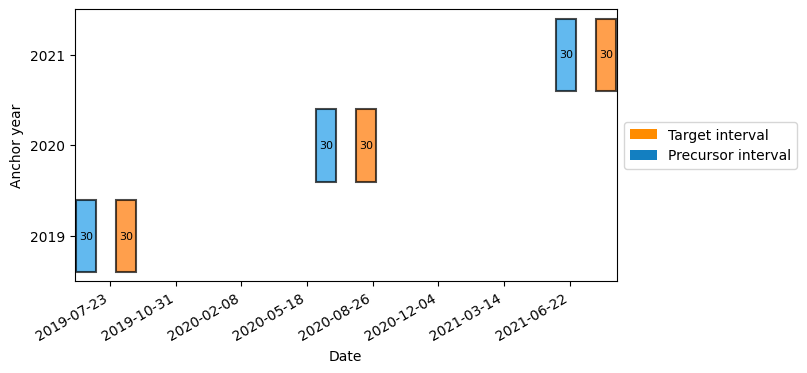

In [7]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

Also, we can get a list of all intervals by running the following line. There, you will find the intervals `-1` and `1`, which corresponds to the creation of a precursor interval (negative integer(s)) and a target interval (positive integer(s)), respectively. <br>

For more information about the definition of intervals, and how `lilio` works, please check the [README](https://github.com/AI4S2S/lilio) of `lilio`.

In [8]:
calendar.show()[:3]

i_interval,-1,1
anchor_year,,
2021,"[2021-06-01, 2021-07-01)","[2021-08-01, 2021-08-31)"
2020,"[2020-06-01, 2020-07-01)","[2020-08-01, 2020-08-31)"
2019,"[2019-06-01, 2019-07-01)","[2019-08-01, 2019-08-31)"


#### Train-validate-test split based on the anchor years (60%/20%/20% split)

In [9]:
# get 60% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.6)
test_samples = round(len(years) * 0.2)
start_year = years[0]

#### Fit preprocessor with training samples and preprocess data
In this step, we remove trend and take anomalies for the precursor field. Note that here we use raw daily data for detrending and taking anomalies. <br>

In general, there are many "flavors" of preprocessing, like when to perform this operation, and in which order do we want to preprocess the data. To improve the transparency and reproducibility of our work, we think it is necessary to standardize these steps. To stick to the best practices, we suggest to preprocess your data in the following way.

In [10]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(
    precursor_field.sel(
        time=slice(str(start_year), str(start_year + train_samples - 1))
    )
)

In [11]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

#### Resample data to the calendar

In [12]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [13]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['t2m'].sel(cluster=3)

We need to convert our data to `torch.Tensor`.

In [14]:
# slice and reshape input desired by transformer
sequence_precursor = len(precursor_field_sel.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_sel.latitude)
lon_precursor = len(precursor_field_sel.longitude)

X_torch = torch.from_numpy(precursor_field_sel[:,:-1,:,:].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_series_sel[:,-1].data).type(torch.FloatTensor)

X_torch = X_torch.view(-1, sequence_precursor, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

We split our data into train/cross-validate/test sets.

In [15]:
# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

#### Build LSTM model
Build a LSTM model with `nn.LSTM` module.

The architecture of the autoencoder used here is shown in the figure below.

<img src="../../assets/lstm.png" alt="LSTM" width="500"/>

(source of image: https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1,
                 batch_size=1, num_layers=1, dropout=0.1):
        """
        Initialize the LSTM model in Pytorch and specify the basic model structure.
        Expected input timeseries dimension [batch_size, sequence, channels]
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim,
                            num_layers = num_layers, batch_first = True, dropout = dropout)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def init_hidden(self):
        """Initialize hidden state with random values."""
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim))
        
    def forward(self, input):
        (h_0, c_0) = self.init_hidden()
        x, _ = self.lstm(input, (h_0, c_0))
        x = self.linear(x)
            
        return x

#### Hyper-parameter tuning with W&B
We use Weight&Biases to monitor the training process. It is very simple to integrate it into our workflow and more information about how to set it up can be found at https://docs.wandb.ai/quickstart. <br>

Print system info.

In [17]:
print ("Pytorch version {}".format(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))

Pytorch version 2.0.1+cu117
Is CUDA available? False
Device to be used for computation: cpu


Define hyperparameters, initialize config for wandb and syncronize training information with W&B server.

In [18]:
# call weights & biases service
wandb.login()

# define hyperparameters and the 
hyperparameters = dict(
    epoch = 150,
    input_dim = lat_precursor*lon_precursor,
    hidden_dim = lat_precursor*lon_precursor*2,
    output_dim = 1,
    batch_size = 1, 
    num_layers = 2,
    dropout = 0.0,
    learning_rate = 0.02,
    dataset = 'Weather',
    architecture = 'LSTM'
)

# initialize weights & biases service
#mode = 'online'
mode = 'disabled'
wandb.init(config=hyperparameters, project='test-LSTM', entity='ai4s2s', mode=mode)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: git-yang (ai4s2s). Use `wandb login --relogin` to force relogin


Create data loaders with chosen batch size. 

In [19]:
# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

#### Initialize and train model
Create model using specified hyperparameter. Initialize model and choose loss function and optimizer.

In [20]:
# Initialize model
model = LSTM(input_dim = config["input_dim"],
             hidden_dim = config["hidden_dim"],
             output_dim = config["output_dim"], 
             batch_size = config["batch_size"], 
             num_layers = config["num_layers"]
)
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)
wandb.watch(model)

Model details:
 LSTM(
  (lstm): LSTM(65, 130, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=130, out_features=1, bias=True)
)
Optimizer details:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.02
    maximize: False
    weight_decay: 0
)


[]

In [21]:
# display the total number of parameters
utils.total_num_param(model)
# for more details about the trainable parameter in each layer
#utils.param_trainable(model)

238811


Start the training and cross validation loop.

In [22]:
# calculate the time for the code execution
start_time = tt.time()

# switch model into training mode
model.train()

hist_train = []
hist_valid = []
for epoch in range(config.epoch):
    # training loop
    # switch model into train mode
    model.train()
    hist_train_step = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).to(device)
        var_y_batch = Variable(y_batch).to(device)
        optimizer.zero_grad()
        # note: decoder input is the last instance of encoder input
        output = model(var_X_batch)
        loss = criterion(output[:,-1,:].squeeze(), var_y_batch) # we only need the last instance from output sequence
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
              f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        hist_train_step += loss.item()

    hist_train.append(hist_train_step / len(train_loader.dataset))

    # cross-validation loop
    # switch model into evaluation mode
    model.eval()
    hist_valid_step = 0

    for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):
        var_X_batch = Variable(X_batch).to(device)
        var_y_batch = Variable(y_batch).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output = model(var_X_batch)
            loss = criterion(output[:,-1,:].squeeze(), var_y_batch)
        wandb.log({'validation_loss': loss.item()})
        hist_valid_step += loss.item()

    hist_valid.append(hist_valid_step / len(valid_loader.dataset))

print (f"--- {(tt.time() - start_time)/60} minutes ---")

/home/yangliu/venv/ai4s2s/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch : 0 [0/37(0%)]	Loss: 512.356995
Epoch : 0 [1/37(3%)]	Loss: 532.600647
Epoch : 0 [2/37(5%)]	Loss: 471.000305
Epoch : 0 [3/37(8%)]	Loss: 451.196320
Epoch : 0 [4/37(11%)]	Loss: 445.542572
Epoch : 0 [5/37(14%)]	Loss: 474.383209
Epoch : 0 [6/37(16%)]	Loss: 353.122925
Epoch : 0 [7/37(19%)]	Loss: 552.876160
Epoch : 0 [8/37(22%)]	Loss: 534.188354
Epoch : 0 [9/37(24%)]	Loss: 444.273376
Epoch : 0 [10/37(27%)]	Loss: 419.256958
Epoch : 0 [11/37(30%)]	Loss: 368.835388
Epoch : 0 [12/37(32%)]	Loss: 531.884644
Epoch : 0 [13/37(35%)]	Loss: 493.005707
Epoch : 0 [14/37(38%)]	Loss: 320.203613
Epoch : 0 [15/37(41%)]	Loss: 395.188507
Epoch : 0 [16/37(43%)]	Loss: 379.495789
Epoch : 0 [17/37(46%)]	Loss: 497.446838
Epoch : 0 [18/37(49%)]	Loss: 233.228424
Epoch : 0 [19/37(51%)]	Loss: 635.468201
Epoch : 0 [20/37(54%)]	Loss: 242.826447
Epoch : 0 [21/37(57%)]	Loss: 477.004608
Epoch : 0 [22/37(59%)]	Loss: 505.621399
Epoch : 0 [23/37(62%)]	Loss: 163.214874
Epoch : 0 [24/37(65%)]	Loss: 492.764923
Epoch : 0 [25/

Now let's check the training loss and validation loss.

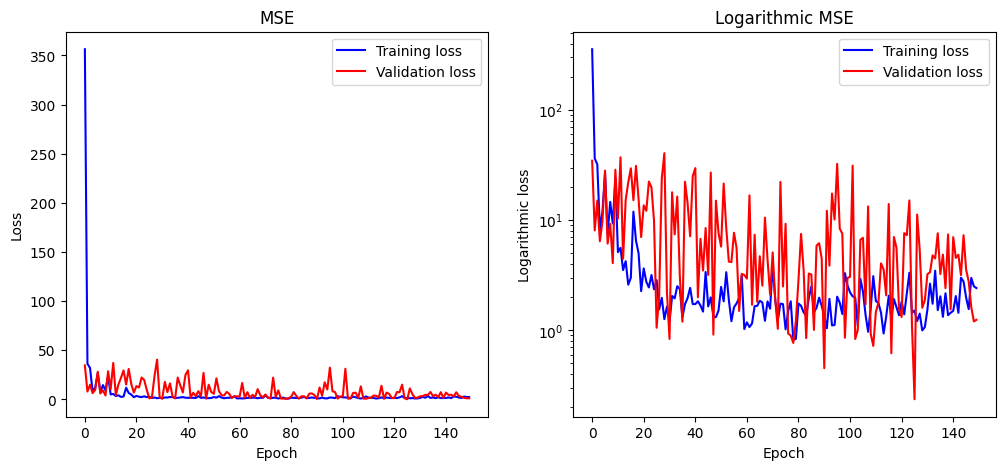

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
plt.plot(np.asarray(hist_train), 'b', label="Training loss")
plt.plot(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("MSE")
plt.legend()

fig.add_subplot(1, 2, 2)
plt.semilogy(np.asarray(hist_train), 'b', label="Training loss")
plt.semilogy(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Logarithmic loss')
plt.title("Logarithmic MSE")
plt.legend()

plt.show()

In [24]:
# save the checkpoint model training if necessary
output_path = "./"

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, Path(output_path,'lstm_train_checkpoint.pt'))

#### Evaluate model
Now we can evaluate our model with testing set and compare the predictions with the ground truth.

In [32]:
# switch model into evaluation mode
model.eval()
hist_test = []
predictions = []
hist_test_step = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = Variable(X_batch).to(device)
    var_y_batch = Variable(y_batch).to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(var_X_batch)
        loss = criterion(output[:,-1,:].squeeze(), var_y_batch)
    wandb.log({'testing_loss': loss.item()})
    predictions.append(output.squeeze().cpu().detach().numpy())
    hist_test_step += loss.item()

hist_test.append(hist_test_step / len(test_loader.dataset))
# call wandb finish to stop logging
wandb.finish()

Plot the predictions versus ground truth.

The MSE loss is 2.236


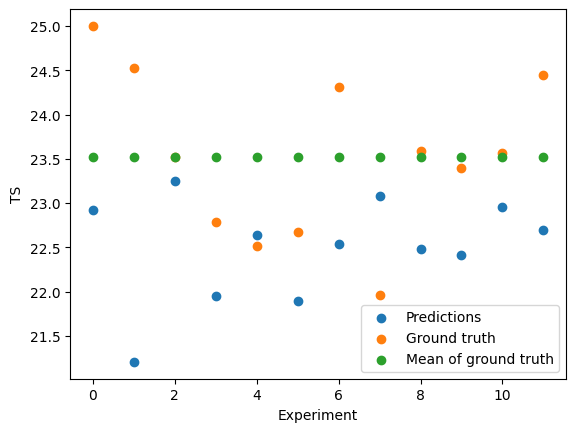

In [37]:
print(f"The MSE loss is {hist_test[0]:.3f}")

fig = plt.figure()
instances = np.arange(len(np.stack(predictions)))
plt.scatter(instances, np.stack(predictions), label="Predictions")
plt.scatter(instances, test_y_torch.squeeze().numpy(), label="Ground truth")
plt.scatter(instances, [test_y_torch.squeeze().numpy().mean()] * len(instances), label="Mean of ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()

#### Explain the LSTM model with LIME.
In the follow section we show how to use LIME to explain our LSTM model with given instance. We use the original LIME explainer (https://github.com/marcotcr/lime/blob/master/lime/lime_tabular.py) to perform the analysis for regression. <br>
Note that LIME only works with single instance explantion (e.g. input must be 1D numpy array 1xn, while n is number of channels/varaibles). Therefore we need to build a model runner to satisfy the requirements.

In [38]:
import lime.lime_tabular

In [39]:
# flatten batch and temporal dimensions for LIME
train_2d = train_X_torch.contiguous().reshape(-1, lat_precursor*lon_precursor).detach().numpy()
train_2d.shape

(37, 65)

In [40]:
# instantialize the lime explainer
explainer = lime.lime_tabular.LimeTabularExplainer(train_2d, feature_names=[str(f"location_{i}") for i in range(lat_precursor*lon_precursor)],
                                                   verbose=True, mode='regression')

In [41]:
# create wrapper function
def predict_fn(input):
    input = torch.from_numpy(input).type(torch.FloatTensor).view(config["batch_size"], -1, lat_precursor*lon_precursor)
    output = model(input)
    return output.squeeze().detach().numpy()

In [42]:
# get the instance to explain
timestep = 0
instance = test_X_torch.contiguous().view(-1, lat_precursor*lon_precursor).detach().numpy()[timestep]
# explain
exp = explainer.explain_instance(instance, predict_fn, num_features=5)

Intercept 24.569766685822135
Prediction_local [24.71313049]
Right: 25.245552


In [43]:
# visualize the explanation from LIME
exp.show_in_notebook(show_table=True)

In [44]:
# check the relative weight
exp.as_list()

[('location_31 > 0.52', -0.3530682348468176),
 ('location_30 > 0.45', -0.27629742941951796),
 ('location_35 <= -0.42', 0.27230595697408067),
 ('location_34 <= -0.76', 0.2530684507721773),
 ('location_21 <= -0.57', 0.24735505736681612)]